# Mini-Project: 전이 학습

> 3.1.6 장에 해당하는 코드

- 이번 미니 프로젝트는 파이토치의 전이 학습 튜토리얼을 많이 참고했다. (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## 필수 패키지 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy

## 데이터 수집, 불러오기 및 전처리

In [2]:
# 코드 3-15

# 훈련(train)과 테스트(val)를 위한 데이터 변형
data_transforms = {
    'train': transforms.Compose([
        # 먼저 이미지에 랜덤한 네모 부분을 선정후 지정 크기만큼 크롭
        transforms.RandomResizedCrop(224), 
        # 0.5의 확률로 수평방향으로의 대칭 이동
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # 이미지 크기 조정
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## 디렉토리구조
# 데이터가 위치한 디렉토리: data_dir
# data_dir
# > train
#   > dog
#   > goat
#   > lamb
# > val
#   > dog
#   > goat
#   > lamb
data_dir = 'data/transferlearning/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True)
              for x in ['train', 'val']}
# 데이터 크기 확인
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# 카테고리 이름 확인 
class_names = image_datasets['train'].classes
# 디바이저 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

## 랜덤으로 크롭된 이미지 확인

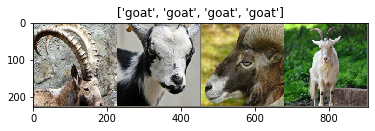

In [3]:
# 코드 3-16

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 정의 및 훈련 함수 작성

In [4]:
# 코드 3-17

def get_model(num_classes, freeze_conv=False):
    """
    num_classes: 
        새로운 분류기를 만들기 위한 카테고리의 개수
    freeze_conv: 
        합성곱 신경망 층은 미리 훈련된 파라미터로 두고, 
        완전 연결층만 바꾼다.
    """
    model = models.resnet18(pretrained=True)
    if freeze_conv:
        for param in model.parameters():
            param.requires_grad = False
    # 최종 fc 층의 입력 크기
    in_feature = model.fc.in_features
    # 새로 정의한 nn.Linear로 바꿔준다.
    model.fc = nn.Linear(in_feature, num_classes)
    return model

# 모델 정의 
model = get_model(len(class_names), freeze_conv=False).to(device)
# 손실함수 정의
loss_function = nn.CrossEntropyLoss()
# 옵티마이저 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\my/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|████████████████████████████████████████████████████████████████| 46827520/46827520 [00:00<00:00, 75004402.85it/s]


In [5]:
def train_model(model, criterion, optimizer, device, n_step=25):
    """
    훈련함수:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    에서 약간 변형
    """
    # 제일 성능이 좋았던 모델의 상태를 저장하기 위한 변수 정의
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for step in range(n_step):
        print('Step {}/{}'.format(step+1, n_step))
        print('-' * 10)

        # 매 스텝마다 훈련과 평가를 반복한다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 훈련 모드로 전환
            else:
                model.eval()   # 모델을 평가 모드로 전환
            
            running_loss = 0.0
            running_corrects = 0

            # 훈련 시작
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 경사 초기화
                optimizer.zero_grad()

                # 순방향 전파
                # 빠른 계산을 위해서 훈련 모드에만 경사를 추적하게 한다
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # 손실값 계산
                    loss = criterion(outputs, labels)

                    # 훈련 단계에서만 역전파 + 매개변수 업데이트를 진행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 한 번의 미니배치의 손실값 및 정확도 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # 한 스텝의 손실값 및 정확도 계산
            step_loss = running_loss / dataset_sizes[phase]
            step_acc = running_corrects.double() / dataset_sizes[phase]

            print('{}\t Loss: {:.4f}\t Acc: {:.4f}'.format(
                phase, step_loss, step_acc))

            # 평가 단계에서만 정확도를 기준으로 모델 상태 저장
            if phase == 'val' and step_acc > best_acc:
                best_acc = step_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # 제일 학습이 좋았던 상태를 불러온다.
    model.load_state_dict(best_model_wts)
    return model

## 모델 훈련

In [6]:
model = train_model(model, loss_function, optimizer, device, n_step=15)

Step 1/15
----------
train	 Loss: 1.0504	 Acc: 0.4727
val	 Loss: 0.5987	 Acc: 0.8333

Step 2/15
----------
train	 Loss: 0.5482	 Acc: 0.8364
val	 Loss: 0.3097	 Acc: 0.8333

Step 3/15
----------
train	 Loss: 0.4419	 Acc: 0.8182
val	 Loss: 0.3692	 Acc: 0.8333

Step 4/15
----------
train	 Loss: 0.3151	 Acc: 0.8545
val	 Loss: 0.4258	 Acc: 0.8333

Step 5/15
----------
train	 Loss: 0.5430	 Acc: 0.7273
val	 Loss: 0.2820	 Acc: 0.8333

Step 6/15
----------
train	 Loss: 0.4181	 Acc: 0.8364
val	 Loss: 0.1035	 Acc: 1.0000

Step 7/15
----------
train	 Loss: 0.3397	 Acc: 0.8727
val	 Loss: 0.3510	 Acc: 0.8333

Step 8/15
----------
train	 Loss: 0.5239	 Acc: 0.7818
val	 Loss: 0.2978	 Acc: 0.8333

Step 9/15
----------
train	 Loss: 0.2747	 Acc: 0.8909
val	 Loss: 0.1646	 Acc: 1.0000

Step 10/15
----------
train	 Loss: 0.3018	 Acc: 0.8545
val	 Loss: 0.3074	 Acc: 0.8333

Step 11/15
----------
train	 Loss: 0.4805	 Acc: 0.8364
val	 Loss: 0.1456	 Acc: 1.0000

Step 12/15
----------
train	 Loss: 0.3487	 Acc: 0.87

# 테스트

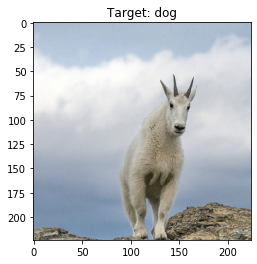

In [7]:
# 코드 3-18

# 테스트 데이터 전처리 및 확인
test_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), test_tf)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
inputs, label = next(iter(test_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title="Target: "+class_names[label])

In [8]:
# 테스트 이미지 예측
pred = model(inputs.to(device)).argmax(1)
print(class_names[pred])

goat
